In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import corner
from VegasAfterglow import ObsData, Setups, Fitter, ParamDef, Scale

In [2]:
######### 1. PREPARE DATA #########
# Prepare your data in .csv format, following the format of example data.
# Create an instance of the ObsData class to store light curve and spectrum data
data = ObsData()

# Define the frequency bands [Hz] and corresponding light curve files
band = [6.29E+14, 4.81E+14, 3.94E+14, 3.29E+14, 2.40E+14, 1.82E+14, 1.36E+14, 4.35E+14, 3.43E+14]
# lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]
lc_files = ["data/080413B.csv"]

# Loop through each frequency band and corresponding file(s)
for nu, fname in zip(band, lc_files):
    # Read the light curve data from the CSV file into a pandas DataFrame
    df = pd.read_csv(fname)


    # Add the light curve data to the 'data' object for the given frequency band, you can assign weight to each data point for chi^2 evaluation
    # You don't need to worry about the weights' normalization, the code will normalize them automatically.
    sel = df[df["Wave"] == nu]
    data.add_flux_density(
        nu=nu,
        t=sel["Time"].values,
        f_nu=sel["Value"].values * 1e-26,      
        err=sel["ValueUpper"].values * 1e-26,
        weights=np.ones(len(sel))
    )

# Define the times [s] for spectra and corresponding files
# Use the already-loaded DataFrame `df` to get unique spectrum times (sorted, no NaNs)
times = np.sort(df["Time"].dropna().unique())
spec_files = ["data/080413B.csv"]    

# Loop through each time and its corresponding spectrum file
for t, fname in zip(times, spec_files):
    # Read the spectrum data from the CSV file into a pandas DataFrame
    df_spec = pd.read_csv(fname)

    # Add the spectrum data to the 'data' object for the given time
    sel = df_spec[df_spec["Time"] == t]
    data.add_spectrum(t=t, nu=sel["Wave"],
                      f_nu=sel["Value"], err=sel["ValueUpper"], weights=np.ones(len(sel["Wave"])))  # All quantities in CGS units

######### 2. CONFIGURE MODEL #########
cfg = Setups()
cfg.lumi_dist = 2.22E28    # Luminosity distance [cm]  
cfg.z         = 1.1       # Redshift
cfg.medium    = "wind"      # Medium type: "wind", "ism" (Interstellar Medium)
cfg.jet       = "powerlaw"  # Jet structure: "powerlaw", "gaussian", "tophat", "two_component", "step_powerlaw" 
######### 3. DEFINE PARAMETERS #########
# Parameter name, lower bound, upper bound, scale type
# Scale.LOG means we sample log10(x), then transform via 10**v.
# Scale.LINEAR means we sample linearly
# Scale.FIXED means this param never appears in the sampler.

mc_params = [
    ParamDef("E_iso",    1e50,  1e54,  Scale.LOG),       # Isotropic energy [erg]
    ParamDef("Gamma0",      5,  1000,  Scale.LOG),       # Lorentz factor at the core
    ParamDef("theta_c",   0.0,   0.5,  Scale.LINEAR),    # Core half-opening angle [rad]
    ParamDef("k_e",         2,     2,  Scale.FIXED),     # Energy power law index
    ParamDef("k_g",         2,     2,  Scale.FIXED),     # Lorentz factor power law index
    ParamDef("theta_v",   0.0,   0.0,  Scale.FIXED),     # Viewing angle [rad]
    ParamDef("p",           2,     3,  Scale.LINEAR),    # Power law index
    ParamDef("eps_e",    1e-2,   0.5,  Scale.LOG),       # Electron energy fraction
    ParamDef("eps_B",    1e-4,   0.5,  Scale.LOG),       # Magnetic field energy fraction
    ParamDef("xi_e",     1e-3,     1,  Scale.LOG),       # Efficiency factor
    ParamDef("A_star",   1e-3,     1,  Scale.LOG),       # Wind parameter 
    ParamDef("k_m",         1,     4,  Scale.LINEAR),     # Mass loss rate power law index (maybe?)
]

######### 4. RUN MCMC #########
# Create an instance of the MCMC Fitter class using the prepared data and configuration
fitter = Fitter(data, cfg)

# Run the fitting process using the defined parameters for specified number of MCMC steps (total_steps)
result = fitter.fit(
    mc_params,
    resolution=(0.3, 1, 10),#resolution of the grid, the optimal resolution is data dependent, you may change it based on your data
    total_steps=10000,
    burn_frac=0.3,
    top_k=10
)

# Create a table for top-k parameters
top_k_data = []
for i in range(result.top_k_params.shape[0]):
    row = {'Rank': i+1, 'chi^2': f"{-2*result.top_k_log_probs[i]:.2f}"}
    for name, val in zip(result.labels, result.top_k_params[i]):
        row[name] = f"{val:.4f}"
    top_k_data.append(row)

top_k_df = pd.DataFrame(top_k_data)
print("Top-k parameters:")
print(top_k_df.to_string(index=False))

100%|██████████| 10000/10000 [04:57<00:00, 33.64it/s]


Top-k parameters:
 Rank  chi^2   E_iso Gamma0 theta_c      p   eps_e   eps_B    xi_e  A_star    k_m
    1 126.46 52.8122 2.9227  0.4303 2.4667 -0.4886 -0.5015 -0.7298 -2.3577 1.8504
    2 127.19 52.8021 2.9277  0.4396 2.4734 -0.4774 -0.4304 -0.7001 -2.4131 1.8494
    3 127.59 52.7281 2.7029  0.4683 2.4879 -0.5224 -0.9484 -0.8728 -1.9971 1.8675
    4 127.65 52.7989 2.9312  0.4385 2.4771 -0.4722 -0.4087 -0.6899 -2.4291 1.8473
    5 127.67 52.7631 2.8327  0.4726 2.4979 -0.5171 -0.7816 -0.8221 -2.1267 1.8498
    6 127.70 52.7398 2.7950  0.4890 2.5139 -0.5181 -0.8499 -0.8380 -2.0687 1.8513
    7 127.72 52.8437 2.9681  0.4136 2.4408 -0.5013 -0.4540 -0.7361 -2.3995 1.8439
    8 127.76 52.7554 2.7245  0.4689 2.4751 -0.5391 -1.0174 -0.8977 -1.9524 1.8678
    9 127.79 52.7323 2.7824  0.4945 2.5191 -0.5193 -0.8785 -0.8454 -2.0448 1.8518
   10 127.85 52.9457 2.8539  0.3437 2.3927 -0.4931 -1.2652 -0.9438 -1.7629 1.8455


In [3]:
# Define time and frequency ranges for predictions
t_out = np.logspace(2, 9, 150)

nu_out = np.logspace(16,20,150)

best_params = result.top_k_params[0]

# Generate model light curves at the specified bands using the best-fit parameters
lc = fitter.flux_density_grid(best_params, t_out, band)

# Generate model spectra at the specified times using the best-fit parameters
spec = fitter.flux_density_grid(best_params, times, nu_out)

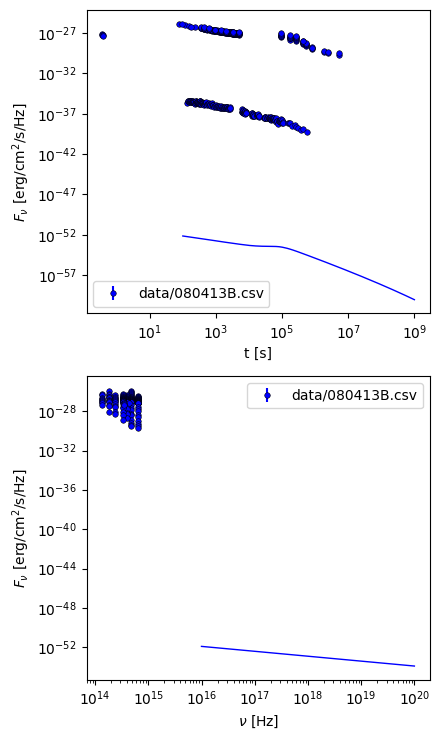

In [4]:
# Function to plot model light curves along with observed data
def draw_bestfit(t,lc_fit, nu, spec_fit):
    fig =plt.figure(figsize=(4.5, 7.5))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    shift = [1E-26,1E-26,200E-26]
    colors = ['blue', 'orange', 'green']
    for i, file, sft, c in zip(range(len(lc_files)), lc_files, shift, colors ):
        df = pd.read_csv(file)
        ax1.errorbar(df["Time"], df["Value"]*sft, df["ValueUpper"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax1.plot(t, np.array(lc_fit[i,:])*sft, color=c,lw=1)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax1.legend()
  
    for i, file, sft, c in zip(range(len(spec_files)), spec_files, shift, colors ):
        df = pd.read_csv(file)
        ax2.errorbar(df["Wave"], df["Value"]*sft, df["ValueUpper"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax2.plot(nu, np.array(spec_fit[:,i])*sft, color=c,lw=1)

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\nu$ [Hz]')
    ax2.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax2.legend()
    plt.tight_layout()

draw_bestfit(t_out, lc, nu_out, spec)

Corner plot saved to: corner_plot_g.png


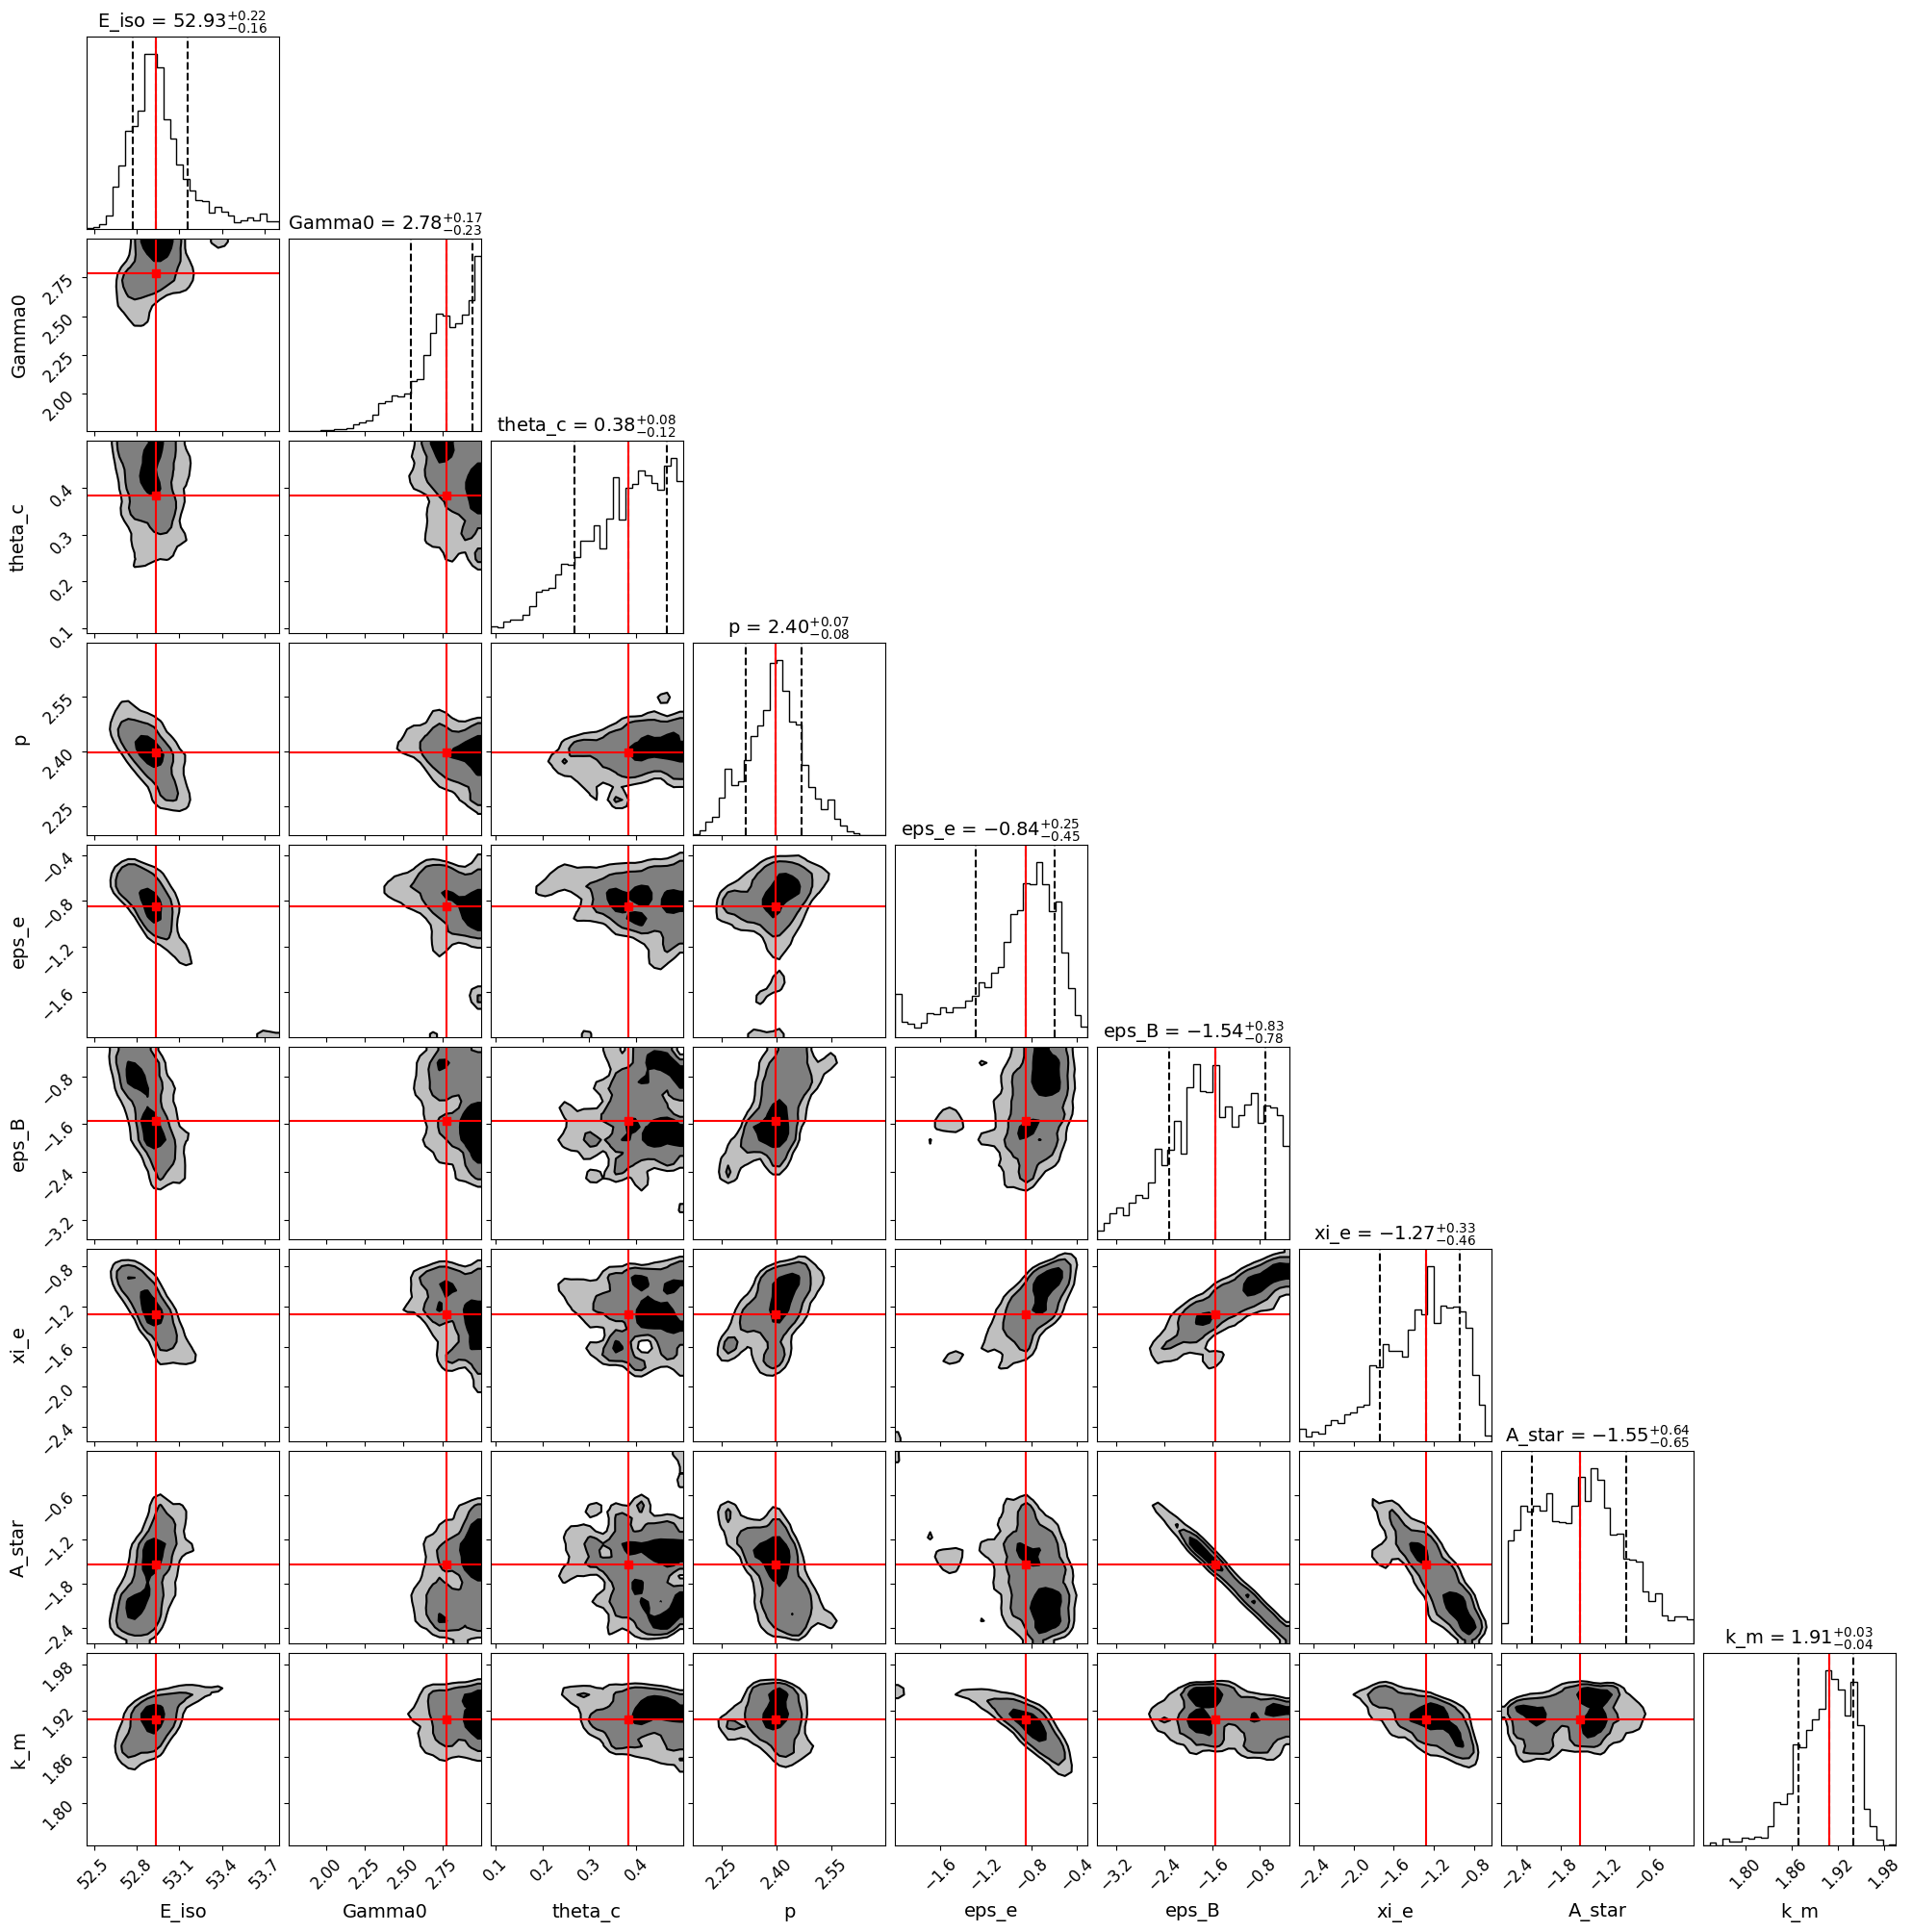

In [5]:
# Function to create a corner plot showing parameter correlations and confidence intervals
def plot_corner(flat_chain, labels, filename="corner_plot.png"):
    fig = corner.corner(
        flat_chain,
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],  # For median and ±1σ
        show_titles=True,
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
        #range=ranges,  # Optional: constrain plot ranges
        truths=np.median(flat_chain, axis=0),  # Show median values
        truth_color='red',
        smooth=1,
        bins=30,  # Number of bins in histograms
        plot_datapoints=False,
        fill_contours=True,
        levels=[0.16, 0.5, 0.68],  # 1σ and 2σ contours
        color='k',
        alpha=0.5
    )
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12) 
    fig.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Corner plot saved to: {filename}")

# Function to make a trace plot to show MCMC convergence over steps
def plot_trace(chain, labels, filename="trace_plot.png"):
    nsteps, nwalkers, ndim = chain.shape
    fig, axes = plt.subplots(ndim, figsize=(10, 2.5 * ndim), sharex=True)

    for i in range(ndim):
        for j in range(nwalkers):
            axes[i].plot(chain[:, j, i], alpha=1,lw=0.5)
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True)
    
    axes[-1].set_xlabel("Step")
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Trace plot saved to: {filename}")

#plot_trace(result.samples, result.labels, filename="trace_plot.png")

flat_chain = result.samples.reshape(-1, result.samples.shape[-1])

plot_corner(flat_chain, result.labels, filename="corner_plot_g.png")